<a href="https://colab.research.google.com/github/HARASEON/Deep_Learning_tensorflow/blob/main/Day3_Transfer_Learning_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

이미 만들어진 모델을 사용하여 새로운 모델을 만드는 방법
* 기존 모델 찾는 곳: tensorflow hub, keras, hugginface
* 학습을 빠르게 하며, 예측력을 더 높일 수 있음
* Pre-Trained Model=Foundation model = 이미 학습이 완료된 모델
* 망이 깊어지면 성능이 좋아진다?
  * Not always, VGG16과 VGG19성능 비슷하고 ResNet56layer < ResNet26layer 이다.
  * VGG16: 커널사이즈 3*3 고정,13CNN+ 3Fully connected layers, 1strid & 1padding, 2*2 max pooling -> image resize, ReLU
  * ResNet: layer의 입력을 layer의 출력에 바로 연결(입력값이 중간의 특정 레이어를 거치지 않음)시키는 'skip connection'사용

* Fine tuning 방법
  * Feature extraction
  * Pre-trained model을 모델 구조를 이용
  * 다른 레이어를 고정시키고 일부분 layer를 조정


# 모델경량화 (On-device AI) vs 초거대AI(Large Language Model, LLM)
* 모델경량화
  * 학습된 모델의 크기를 줄이는 방법
    - Pruning: 상대적으로 덜 중요한 weight연결을 삭제하는 방법
    - Quantization: 양자화, 학습된 딥러닝 모델이 weight값을 저장할 때 사용하는 비트의 수를 줄여서 모델의 크기를 줄이는 방법(ex. weight 값 저장 시, FP16 또는 INT8로 표현 가능한 범위의 숫자로 변환한 뒤 해당 비트 수 만큼의 메모리에 저장하는 방법
    - 장점: 모델 추론시 동작시간 단축
  * 네트워크 구조 자체를 효율적으로 설계
    - SqueezeNet: Fire Moule이라는 구조 제안
    - MobileNet: Depthwise Separable Convolutions 구조를 적절히 활용해 모바일 디바이스에서 동작가능한 수준의 경량한 구조를 제안했고, 구조를 더욱 개량해 버전 3까지 발표
    - ShuffleNet: Depthwise Separable Convolutions된 결과를 섞어서(Shuffle) 경량화되었지만 성능이 좋은 네트워크를 만듦
* 초거대AI
  * GPT-3
  * 대규모의 파라미터

# Cats and Dogs

* Dataset: 25000개의 고양이와 개의 이미지 
  * 개 -12500, 고양이- 12500
* Goal < 0.24087

# 손으로 짜는 코드
* CNN only
* Goal < 0.24087
success! 0.17957

In [12]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load dataset
# train : test = 8:2
Batch_size = 32
Epochs = 50
dataset_name = 'cats_vs_dogs'
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_dataset, validation_dataset), info = tfds.load(name=dataset_name, split = ('train[:80%]', 'train[-20%:]'), with_info = True)

# Data preprocessing
def normalize(images):
  # data normalizatioon
  img, lable = tf.cast(images['image'], tf.float32)/255.0, images['label']
  # resize 224*224(colour image)
  img= tf.image.resize(img, size=(224,224))
  return img, lable

train_data = train_dataset.map(normalize).batch(Batch_size)
valid_data = validation_dataset.map(normalize).batch(Batch_size)

# Design Model= Model Building = Graph design
model_cnn = Sequential([
    Conv2D(32, (3,3), activation = 'relu', input_shape=(224,224,3), padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Conv2D(32, (3,3), activation = 'relu', padding = 'same'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
model_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# model monitoring
early_stopping = EarlyStopping(monitor = 'val_loss', patience =10)
checkpoint_path = 'checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only = True,
                             save_weights_only = True,
                             monitor = 'val_loss',
                             verbose = 1)
# model fitting
cnn_history = model_cnn.fit(train_data,
                            validation_data = (valid_data),
                            epochs = Epochs,
                            callbacks = [checkpoint, early_stopping])
model_cnn.load_weights(checkpoint_path)
model_cnn.save("cats-vs-dogs-cnn.h5")


Epoch 1/50
582/582 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5373
Epoch 1: val_loss improved from inf to 0.66664, saving model to checkpoint.ckpt
582/582 [==============================] - 14s 18ms/step - loss: 0.6884 - accuracy: 0.5373 - val_loss: 0.6666 - val_accuracy: 0.5935
Epoch 2/50
579/582 [============================>.] - ETA: 0s - loss: 0.6566 - accuracy: 0.6125
Epoch 2: val_loss improved from 0.66664 to 0.63210, saving model to checkpoint.ckpt
582/582 [==============================] - 10s 17ms/step - loss: 0.6565 - accuracy: 0.6127 - val_loss: 0.6321 - val_accuracy: 0.6384
Epoch 3/50
579/582 [============================>.] - ETA: 0s - loss: 0.6019 - accuracy: 0.6782
Epoch 3: val_loss improved from 0.63210 to 0.55857, saving model to checkpoint.ckpt
582/582 [==============================] - 10s 17ms/step - loss: 0.6020 - accuracy: 0.6780 - val_loss: 0.5586 - val_accuracy: 0.7145
Epoch 4/50
580/582 [============================>.] - ETA: 0s - l

#ChatGPT version
* transfer model with VGG-16
* val_loss: 0.17988

In [14]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load dataset
# train : test = 8:2
Batch_size = 32
Epochs = 100
dataset_name = 'cats_vs_dogs'
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(train_dataset, validation_dataset), info = tfds.load(name=dataset_name, split = ('train[:80%]', 'train[-20%:]'), with_info = True)

# Data preprocessing
def normalize(images):
  # data normalizatioon
  img, lable = tf.cast(images['image'], tf.float32)/255.0, images['label']
  # resize 224*224(colour image)
  img= tf.image.resize(img, size=(224,224))
  return img, lable

train_data = train_dataset.map(normalize).batch(Batch_size)
valid_data = validation_dataset.map(normalize).batch(Batch_size)

# Design Model= Model Building = Graph design
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

model_cnn = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# model monitoring
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = 'checkpoint.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss',
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.0001)

# model fitting
cnn_history = model_cnn.fit(train_data,
                            validation_data=valid_data,
                            epochs=Epochs,
                            callbacks=[checkpoint, early_stopping, reduce_lr])

model_cnn.load_weights(checkpoint_path)
model_cnn.save("cats-vs-dogs-cnn.h5")


Epoch 1/100
582/582 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.8998
Epoch 1: val_loss improved from inf to 0.45414, saving model to checkpoint.ckpt
582/582 [==============================] - 21s 30ms/step - loss: 0.2446 - accuracy: 0.8998 - val_loss: 0.4541 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 2/100
581/582 [============================>.] - ETA: 0s - loss: 0.1599 - accuracy: 0.9351
Epoch 2: val_loss improved from 0.45414 to 0.17988, saving model to checkpoint.ckpt
582/582 [==============================] - 16s 28ms/step - loss: 0.1598 - accuracy: 0.9351 - val_loss: 0.1799 - val_accuracy: 0.9252 - lr: 0.0010
Epoch 3/100
580/582 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9490
Epoch 3: val_loss did not improve from 0.17988
582/582 [==============================] - 16s 27ms/step - loss: 0.1265 - accuracy: 0.9491 - val_loss: 0.1915 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 4/100
581/582 [============================>.] - ETA: 

# 손으로 짜는 코드
* transfer learning
* VGG16 model 활용
* include_top = False // 원래 모델의 분류기능을 사용하지 않겠다.
* transfer_model.trainable = False // 원래 모델(VGG16)을 다시 학습 시키지 않겠다.
* Goal : 0.24087 > 0.15759 success!

Epoch 1/100
581/582 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9046
Epoch 1: val_loss did not improve from 0.15759
582/582 [==============================] - 17s 27ms/step - loss: 0.2378 - accuracy: 0.9046 - val_loss: 0.1713 - val_accuracy: 0.9280
Epoch 2/100
580/582 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9446
Epoch 2: val_loss did not improve from 0.15759
582/582 [==============================] - 16s 27ms/step - loss: 0.1367 - accuracy: 0.9445 - val_loss: 0.1619 - val_accuracy: 0.9323
Epoch 3/100
580/582 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.9545
Epoch 3: val_loss did not improve from 0.15759
582/582 [==============================] - 16s 27ms/step - loss: 0.1142 - accuracy: 0.9545 - val_loss: 0.1648 - val_accuracy: 0.9336
Epoch 4/100
582/582 [==============================] - ETA: 0s - loss: 0.1048 - accuracy: 0.9582
Epoch 4: val_loss did not improve from 0.15759
582/582 [================

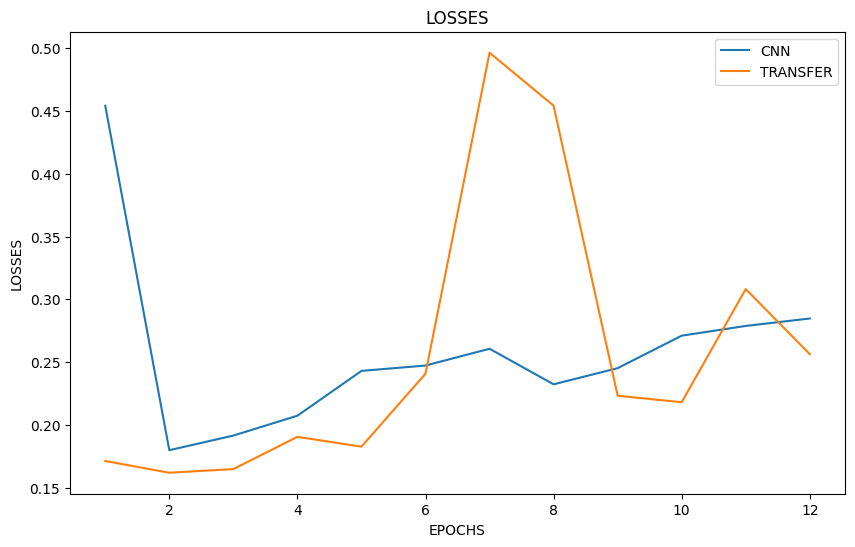

In [18]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

transfer_model = VGG16(weights='imagenet', include_top = False, input_shape = (224,224,3))

transfer_model.trainable=False
model_tr = Sequential([
    transfer_model,
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model_tr.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

transfer_history= model_tr.fit(train_data,
                               validation_data = (valid_data),
                               epochs= Epochs,
                               callbacks = [checkpoint, early_stopping])
model_tr.load_weights(checkpoint_path)
model_tr.save("cats_dogs_tr.h5")

# comparison CNN with Transfer model
epochs_cnn = np.arange(1,len(cnn_history.history['accuracy'])+1)
epochs_tr = np.arange(1, len(transfer_history.history['accuracy'])+1)
print(epochs_cnn, epochs_tr)

if len(cnn_history.history) > len(transfer_history.history):
    EPOCHS = len(cnn_history.history)
else:
    EPOCHS = len(transfer_history.history)
plt.figure(figsize=(10, 6))
plt.plot(epochs_cnn, cnn_history.history['val_loss'], label='CNN')
plt.plot(epochs_tr, transfer_history.history['val_loss'], label='TRANSFER')
plt.xlabel('EPOCHS')
plt.ylabel('LOSSES')
plt.title('LOSSES')
plt.legend()
plt.show()
